<h1>Image Restoration</h1>

In [1]:
# importing some necessay packages
import numpy as np
import matplotlib.pyplot as plt
import skimage
from math import pi
from PIL import Image

<h3>Degrade the given M * N image.png with the following atmospheric turbulence degradation function:- </h3>
    <h1> H(u, v) = exp(-0.0025[u<sup>2</sup> + v<sup>2</sup>]<sup>2</sup> </h1>

<p>Perform inverse filtering on the degraded image at the different levels of zero mean i.i.d. Gaussian noise,
    namely standard deviation = <b>0%, 5%, 10%, 15%, 20%, 25% </b>of maximum intensity in original image. Plot the
    following 2 curves in a graph- <b>(i)</b> RRMSE of degraded image w.r.t. original image versus standard deviation of
    noise. <b>(ii)</b> RRMSE of filtered image w.r.t. original image versus standard deviation of noise.</p>

Shape of the image array : (500, 500)


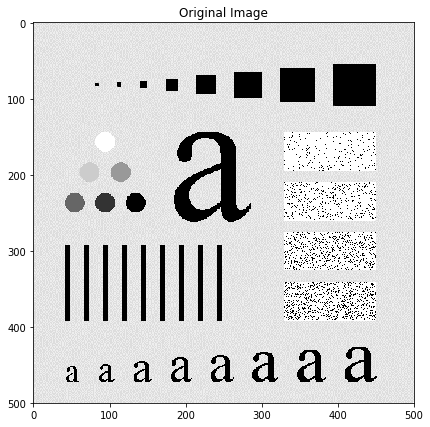

In [2]:
# Let's see how is orginal image
image = np.array(Image.open('./image.png').convert("L"))      ## opening original image
plt.rcParams['figure.figsize'] = (7, 7)
plt.imshow(image, cmap = 'gray')
plt.title("Original Image")
print("Shape of the image array :", image.shape)

In [3]:
# this function is to rescale the image. If we get imaginary matrix then it will take it's absolute
# and normalize all elements of to 0 to 255 so that they can be visualized as an image.
# Helps to plot ffts and iffts.
def rescale(x):
    x = np.abs(x)                   # taking absolute value
    x = x - np.min(x)          
    x = (x * 255) / np.max(x)       # making values of matrix between 0 to 255
    return x

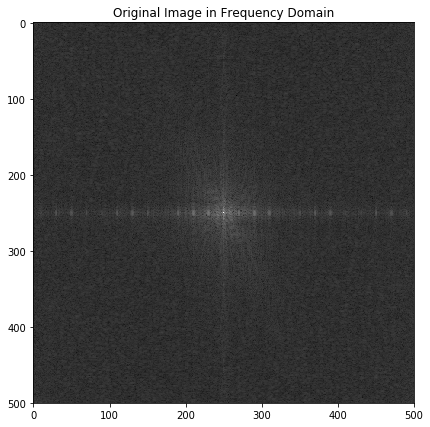

In [4]:
# Let's visualize the image in frequecny domain
image_fft = np.fft.fft2(image, s=image.shape, axes=(-2, -1), norm=None )       # taking fft of orginal image
fft_shifted_image = np.fft.fftshift(image_fft)                                 # applying fftshift to center the fft

plt.imshow(skimage.exposure.adjust_gamma(rescale(fft_shifted_image), 0.20), cmap = 'gray')
plt.title('Original Image in Frequency Domain')
print('')

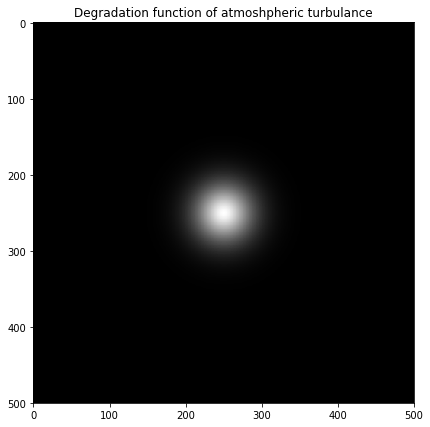

In [5]:
# Now we will make a degradation mask as per requirement of the question.
degradation_maskA = np.zeros(image.shape)

m = degradation_maskA.shape[0]
n = degradation_maskA.shape[1]
# we will loop through each element of the mask and put the values according to the expression given.
for iot in range(m):
    for jot in range(n):
        i = iot - m/2
        j = jot - n/2
        power = 0.0025 * ((i**2 + j**2)**(5/6))               # expression fot the degradation mask
        degradation_maskA[iot, jot] = np.exp(-power)
        
plt.imshow(rescale(degradation_maskA), cmap = 'gray')         # plotting the degradation filter in frequency domain
plt.title('Degradation function of atmoshpheric turbulance')
plt.show()

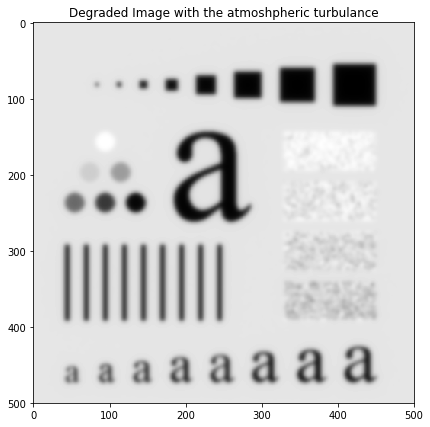

In [6]:
# point wise multiplication of degradation mask with image will result the degraded image
degraded_image_fft = fft_shifted_image * degradation_maskA
degraded_image = np.fft.ifft2(degraded_image_fft, s=None, axes=(-2, -1), norm=None) # taking ifft
degraded_image = rescale(degraded_image) # rescale gets the values between 0 to 255

plt.imshow(degraded_image, cmap = 'gray')
plt.title('Degraded Image with the atmoshpheric turbulance')
plt.show()

<h2> Now let's start adding zero mean i.i.d Gaussian Noise </h2>

In [7]:
# this function takes the argument as standard deviation and generates corresponding iid Gaussian Noise
def gaussian_noise(std):
    np.random.seed(7)
    return np.random.normal(0,std,image.shape)

<h3> Method of implementation : </h3>
<p> As we have six values of standard deviation i.e 0%, 5%, 10%, 15%, 20% and 25%.</p>
<p> So We will make python dictionaries to hold various entities  having keys as string formated(0%, 5%, 10%, 15%, 20% and 25%) to store corresponding values</p>
<p><b>For example :-</b> To hold all six kind of noisy degraded images(with six level of noise) we will use a python dictionary named <b>noisy_degraded_images</b> having keys as <b>0%, 5%, 10%, 15%, 20% and 25%</b> in string format.</p>
 <ul>
    <li><b>noisy_degraded_images["0%"] : </b>    will have degraded image with Noise having 0% standar deviation of max intesity in orginal image.</li>
    <li><b>noisy_degraded_images["5%"] :</b>    will have degraded image with Noise having 5% standar deviation of max intesity in original image.</li>
    <li><b>noisy_degraded_images["10%"] :</b>    will have degraded image with Noise having 10% standar deviation of max intesity in original image.</li>
    <li><b>noisy_degraded_images["15%"] : </b>    will have degraded image with Noise having 15% standar deviation of max intesity in original image.</li>
    <li><b>noisy_degraded_images["20%"] :</b>    will have degraded image with Noise having 20% standar deviation of max intesity in original image.</li>
    <li><b>noisy_degraded_images["25%"] :</b>    will have degraded image with Noise having 25% standar deviation of max intesity in original image.</li>
</ul>

<p> Most of entities like filtered images, their ffts , noise ffts will be stored in similar manner with appropriate name.</p>


In [8]:
noisy_degraded_images = {}  # dictionary containing degraded images with given amount of noise
G_noises = {}               # dictionary containing iid Gaussian noises of various levels.
# Now we will loop through each degraded image and add some the required amount of noise in them
for i in range(0,26, 5):
    G_noises[str(i)+'%'] = gaussian_noise(np.max(image)*(i)/100)
    noisy_degraded_images[str(i)+ '%'] = degraded_image + G_noises[str(i)+'%']

In [9]:
noisy_degraded_images_fft = {}   # FFT of the Gaussian noise added. Will be used to calculate PSD of noise in Wiener Filter
for i in range(0, 26, 5):
    noisy_degraded_images_fft[str(i)+'%']= np.fft.fft2(noisy_degraded_images[str(i)+ '%'], s=image.shape, axes=(-2, -1), norm=None )
    noisy_degraded_images_fft[str(i)+ '%']= np.fft.fftshift(noisy_degraded_images_fft[str(i)+ '%'])

<h1>Let's begin Inverse filtering</h1>

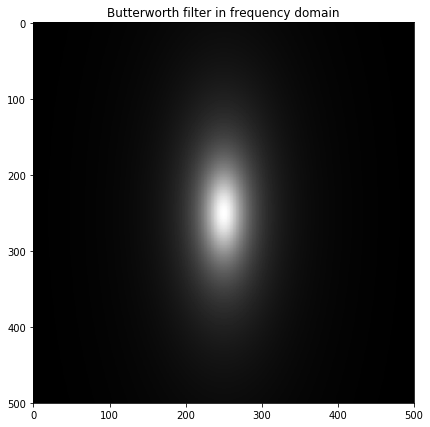

In [10]:
#making a Butterwoth low pass filter mask to use for inverse filtering
butterworth_LP_filter_mask = np.zeros(image.shape)
D0 = 60                  # radius of filter
ORDER = 5                # order of filter
m = butterworth_LP_filter_mask.shape[0]
n = butterworth_LP_filter_mask.shape[1]
# we will loop through each element of the mask and put the values as per the Butterworth filter equation
for i in range(m):
    for j in range(n):
        denom = (1 + ((i -(m/2))**2 + (j -(n/2))**2 * ORDER) / (D0**2))  # denominator of the Butterworth filters
        butterworth_LP_filter_mask[i, j] = 1 / denom

        
butterworth_LP_filter_mask = butterworth_LP_filter_mask.astype(float)

plt.imshow(butterworth_LP_filter_mask, cmap = 'gray')
plt.title("Butterworth filter in frequency domain")
plt.show()

<h2>Inverse Filtering </h2>
<h3>Implementation : </h3>
    <p> We loop through all the values of degradation mask and see the values. If the values are lower than
    a particular threshold then we put zero as result of division of degraded image fft element  by degradation mask and if above that threshold then we perform actual division. <br>This is done to avoid getting very high values after Inverse filtering due to division by small number.<br> Equation implemented for inverse filtering is as following :</p>
    <h3><b>F<sub>est</sub>(u,v) = F(u,v) + N(u,v)/H(u,v)</b></h3>
    <p>We will also use low pass pass filter to zero out unnecessary elements.
    

In [11]:
# Here we will perform Inverse Filtering
inverse_filtered_fft = {}    # python dictionary of IFFT of  restored images using inverse filtering
for index in range(0, 26, 5):
    inverse_filtered_fft[str(index)+ '%'] = (0+0j)*np.zeros(degradation_maskA.shape)
    
    for i in range(degradation_maskA.shape[0]):
        for j in range(degradation_maskA.shape[1]):
            
            if degradation_maskA[i, j] < 0.1: # we put resultant values zero if element is less than this threshold
                inverse_filtered_fft[str(index)+ '%'][i, j] = 0
            else:
                inverse_filtered_fft[str(index)+ '%'][i, j] = noisy_degraded_images_fft[str(index)+ '%'][i,j] / degradation_maskA[i, j]
                
    inverse_filtered_fft[str(index)+'%'] *= butterworth_LP_filter_mask

In [12]:
inverse_filtered_images = {}    # dictionary containing restored images using Inverse Filtering
for i in range(0, 26, 5):
    inverse_filtered_images[str(i)+"%"] = rescale(np.fft.ifft2(inverse_filtered_fft[str(i)+ '%'], s=None, axes=(-2, -1), norm=None))

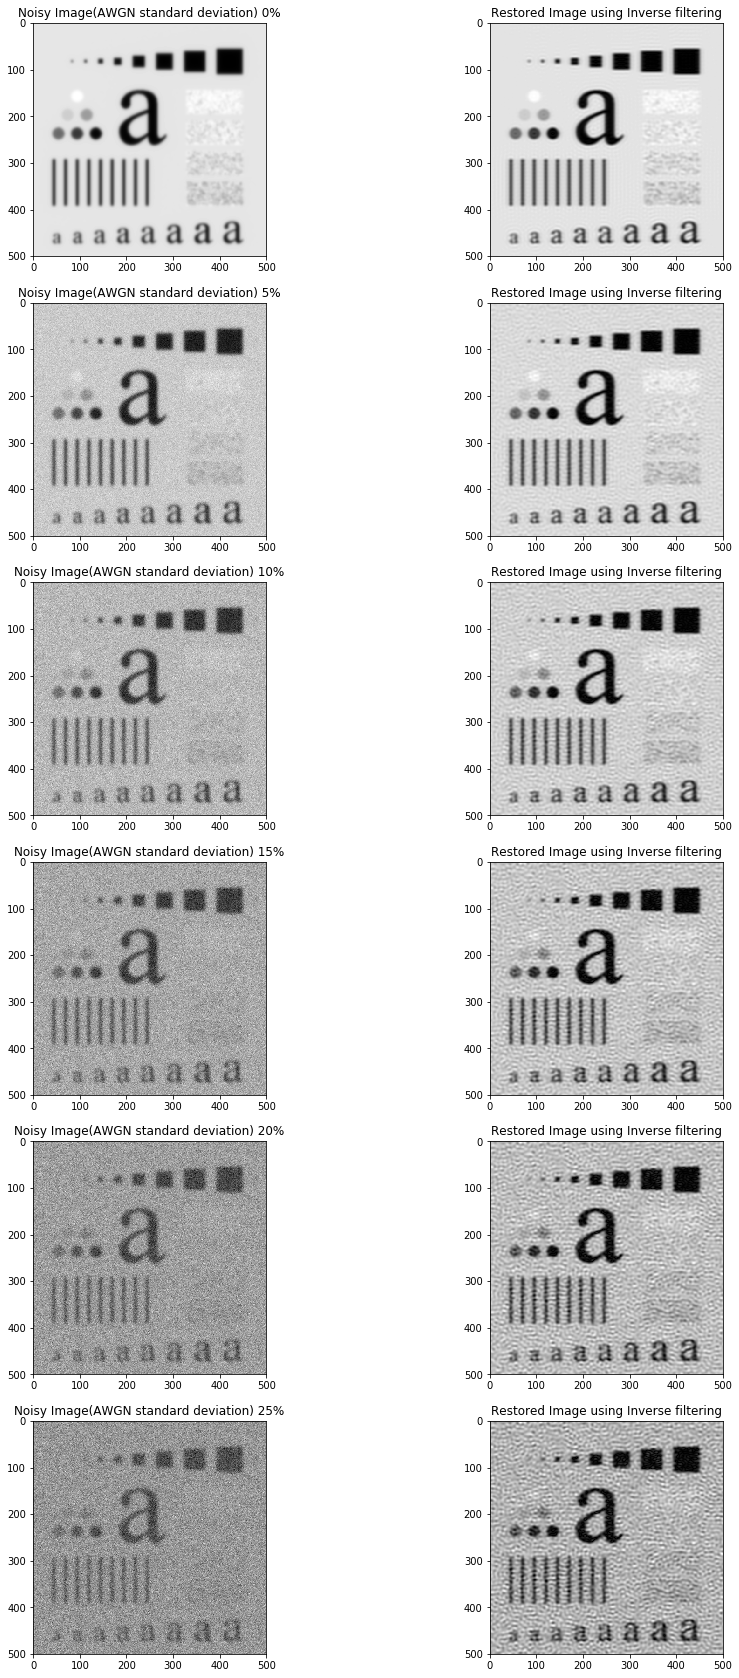

In [13]:
# Plotting the noisy degraded images and their corresponding restored images using Inverse filtering
fig = plt.figure(figsize = (15,30))
count = 1
for index in range(0, 26, 5):
    ax = fig.add_subplot(6, 2, count)
    plt.imshow(noisy_degraded_images[str(index)+'%'], cmap = 'gray')
    ax.set_title("Noisy Image(AWGN standard deviation) "+ str(index)+'%')
    
    ax = fig.add_subplot(6, 2, count+1)
    plt.imshow(inverse_filtered_images[str(index)+'%'], cmap = 'gray')
    ax.set_title("Restored Image using Inverse filtering")
    count += 2

In [14]:
def rrmse(B, A):
    """ Calculate RRMSE of matrix B wrt matrix A
    args : B - matrix
           A - matrix
    return RMMSE of matrix B wrt matrix A
    """
    # implementation of RRMSE formula
    A, B = A/255, B/255        # normalizing the pixel values to avoid out of bound problems
    numerator = np.sum(np.square(A-B))
    denominator = np.sum(np.square(A))
    ratio = np.divide(numerator , denominator)
    
    return np.sqrt(ratio)

<h3>(i) RRMSE of degraded image w.r.t. original image versus standard deviation of noise
<br>(ii) RRMSE of inverse filtered image w.r.t. original image versus standard deviation of noise.</h3>

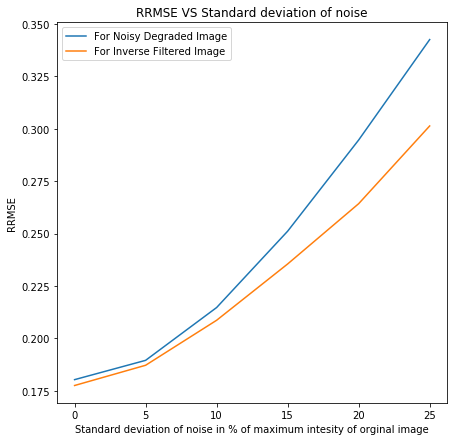

In [15]:
# We will loop through all degraded images using their dictionary and calculate RRMSE for each of them
# wrt orinal image and save the value to a list for plotting
RRMSE = []   # List in which we will save the RRMSE values for each six different standard deviation values
for i in range(0, 26, 5):
    RRMSE.append(rrmse(noisy_degraded_images[str(i)+'%'], image))

plt.plot(np.arange(0,26, 5), RRMSE , label = 'For Noisy Degraded Image')            # plotting the RRMSE values wrt std

RRMSE = []   # List in which we will save the RRMSE values for each six different standard deviation values
for i in range(0, 26, 5):
    RRMSE.append(rrmse(inverse_filtered_images[str(i)+'%'], image))

plt.plot(np.arange(0,26, 5), RRMSE, label = 'For Inverse Filtered Image')            # plotting the RRMSE values wrt std
plt.xlabel("Standard deviation of noise in % of maximum intesity of orginal image")
plt.ylabel("RRMSE")
plt.title("RRMSE VS Standard deviation of noise")
plt.legend()
plt.show()

<h1>part b)</h1> 
<p>Perform inverse filtering on the degraded image at the different levels of zero mean i.i.d. Gaussian noise,
    namely standard deviation = <b>0%, 5%, 10%, 15%, 20%, 25% </b>of maximum intensity in original image. Plot the
    following 2 curves in a graph- <b>(i)</b> RRMSE of degraded image w.r.t. original image versus standard deviation of
    noise. <b>(ii)</b> RRMSE of filtered image w.r.t. original image versus standard deviation of noise.</p>

In [16]:
# This is needed for Wiener Filtering
gaussian_noise_PSDs = {}  # dictionary of Gaussian Noise's PSDs
for i in range(0, 26, 5):
    x = np.fft.fft2(G_noises[str(i)+ '%'], s=image.shape, axes=(-2, -1), norm=None )
    x = np.fft.fftshift(x)
    gaussian_noise_PSDs[str(i) + '%'] = np.square(np.abs(x))    

<h1> Wiener Filtering</h1>
<h3> Implementation : </h3>
<p> We will implement the Wiener filtering by the equation given in the book. <br> Equation for Wiener filtering is: </p>
<h3> F<sub>est</sub> = F *|H(u,v)|<sup>2</sup> / (H(u,v) * (|H(u,v)|<sup>2</sup> + PSD<sub>noise</sub> / PSD<sub>image</sub>) </h3> 

In case of noise with standard deviation of 0% of maximum image intensity, PSD of noise becomes zero so Wiener filter
turns into Inverse filter so we will be again facing the issue of division by small number. So we will have to do
some changes to make our Wiener filter work for even Images having no noise.

In [17]:
wiener_filtered_images = {}   # save Wiener filtered images into a dicationary
for i in range(0, 26, 5):
    if i == 0 :
        K = 0.1                 # K becomes 0 so we manully set some value to K to avoid problems of Inverse filtering
    else:
        K = gaussian_noise_PSDs[str(i) + '%'] / np.square(np.abs(fft_shifted_image)) # calculating (PSDnoise / PSDimage)
    
    # below line is is implementation of Wiener filter as described above
    temp = np.square(np.abs(degradation_maskA)) / (degradation_maskA *(np.square(np.abs(degradation_maskA)) + K))

    fft_im = noisy_degraded_images_fft[str(i)+'%'] * temp         # pointwise multiplication with Wiener Filter
    wiener_filtered_images[str(i)+'%'] = rescale(np.fft.ifft2(fft_im, s=None, axes=(-2, -1), norm=None)) # getting Filterd images

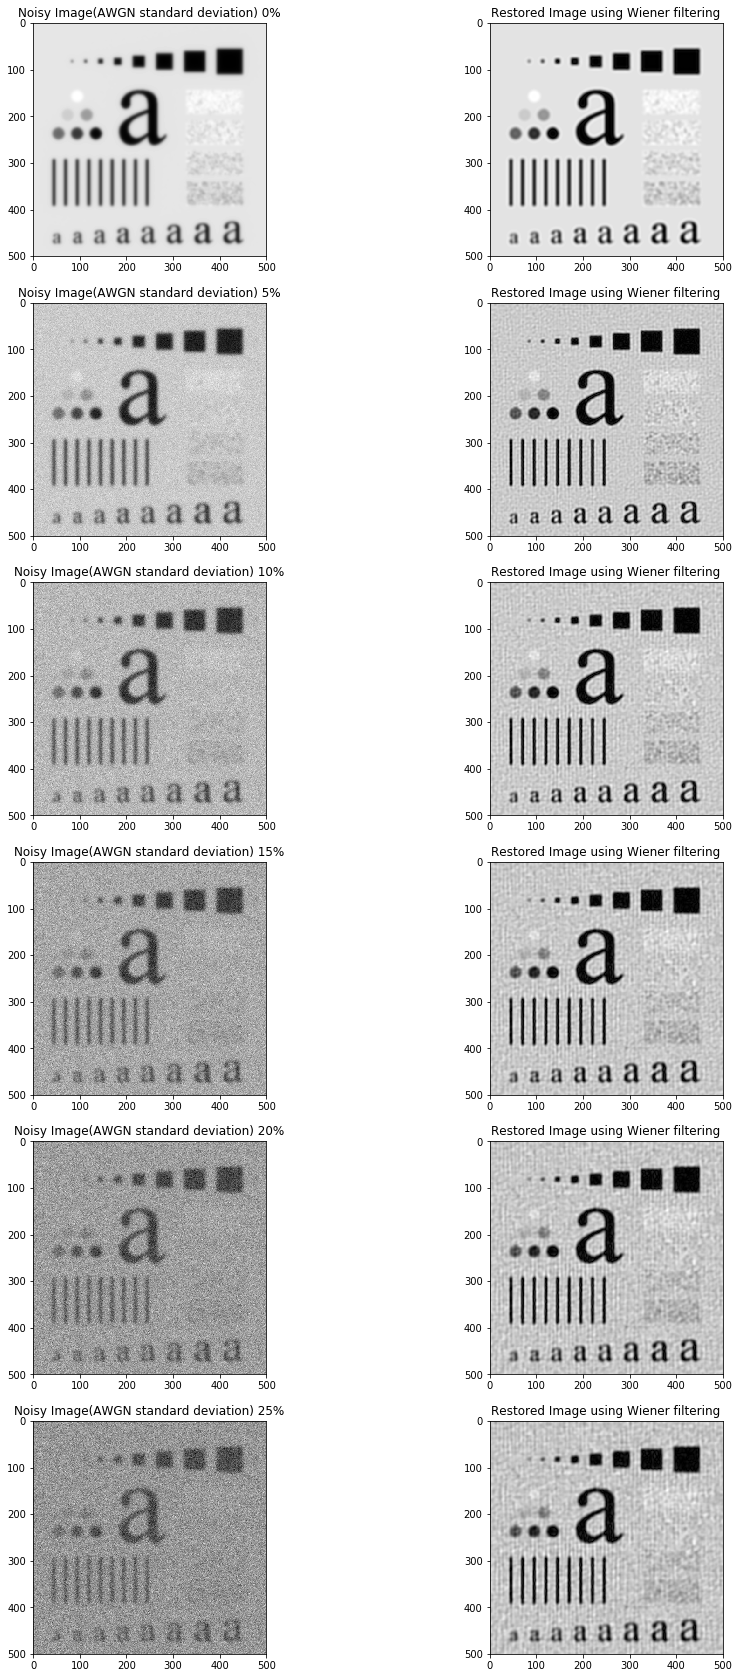

In [18]:
#Now plotting the images
fig = plt.figure(figsize = (15,30))
count = 1
for index in range(0, 26, 5):
    ax = fig.add_subplot(6, 2, count)
    plt.imshow(noisy_degraded_images[str(index)+'%'], cmap = 'gray')
    ax.set_title("Noisy Image(AWGN standard deviation) "+ str(index)+'%')
    
    ax = fig.add_subplot(6, 2, count+1)
    plt.imshow(wiener_filtered_images[str(index)+'%'], cmap = 'gray')
    ax.set_title("Restored Image using Wiener filtering")
    count += 2

<h3>(i) RRMSE of degraded image w.r.t. original image versus standard deviation of noise
    <br>(ii) RRMSE of Wiener filtered image w.r.t. original image versus standard deviation of noise.</h3>

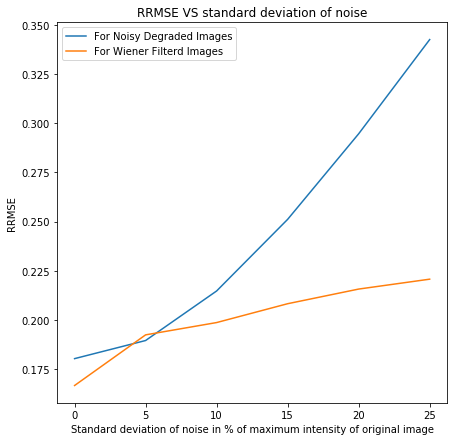

In [19]:
# We will loop through all inverse images using their dictionary and calculate RRMSE for each of them
# wrt orinal image and save the value to a list for plotting
RRMSE = []   # List in which we will save the RRMSE values for each six different standard deviation values
for i in range(0, 26, 5):
    RRMSE.append(rrmse(noisy_degraded_images[str(i)+'%'], image))

plt.plot(np.arange(0,26, 5), RRMSE , label = 'For Noisy Degraded Images')

RRMSE = []   # List in which we will save the RRMSE values for each six different standard deviation values
for i in range(0, 26, 5):
    RRMSE.append(rrmse(wiener_filtered_images[str(i)+'%'], image))

plt.plot(np.arange(0,26, 5), RRMSE, label = 'For Wiener Filterd Images')
plt.xlabel("Standard deviation of noise in % of maximum intensity of original image")
plt.ylabel("RRMSE")
plt.title("RRMSE VS standard deviation of noise")
plt.legend()
plt.show()

<h3>Degrade the given M x N image image.png with the following motion blurring degradation function-</h3>
    <h2><b>H(u, v) = [0.001 + sin(π(0.1u + 0.1v))]exp⁡(−jπ(0.1u + 0.1v))0. 001 + π(0.1u + 0.1v)</b></h2>

<h2>a)</h2> 
<p>Perform inverse filtering on the degraded image at the different levels of zero mean i.i.d. Gaussian noise,
    namely standard deviation = <b>0%, 5%, 10%, 15%, 20%, 25% </b>of maximum intensity in original image. Plot the
    following 2 curves in a graph- <b>(i)</b> RRMSE of degraded image w.r.t. original image versus standard deviation of
    noise. <b>(ii)</b> RRMSE of filtered image w.r.t. original image versus standard deviation of noise.

In [20]:
# Let's get the image in frequecny domain
image_fft = np.fft.fft2(image, s=(image.shape), axes=(-2, -1), norm=None )       # taking fft of orginal image
fft_shifted_image = np.fft.fftshift(image_fft)                                 # applying fftshift to center the fft

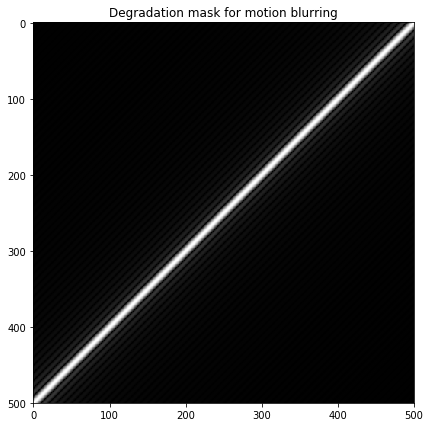

In [21]:
# making degradation mask using the above given equation in the same way as we did in first question
degradation_maskB = (0+0j) *np.zeros((fft_shifted_image.shape[0], fft_shifted_image.shape[1]))

m = degradation_maskB.shape[0]
n = degradation_maskB.shape[1]
for iot in range(m):
    for jot in range(n):
        x = iot - m/2
        y = jot - m/2
        temp1 = 1 / (0.001 + pi*0.1*(x+y))
        temp2 = 0.001 + np.sin(pi*0.1*(x+y))
        degradation_maskB[iot, jot] = temp1 * temp2 * np.exp(-pi*(x+y)* 0.1j)   # implementation of degradation mask     
plt.imshow(rescale(degradation_maskB), cmap = 'gray')
plt.title('Degradation mask for motion blurring')
plt.show()

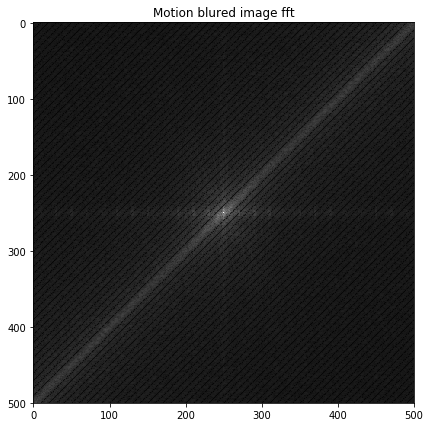

In [22]:
# Pointwise multiplication of degradation mask with FFT of original image to get desired effect
degraded_image_fft = fft_shifted_image * degradation_maskB
plt.imshow(skimage.exposure.adjust_gamma(rescale(degraded_image_fft), 0.18) ,cmap = 'gray') # gammma adjusted plot
plt.title('Motion blured image fft')
plt.show()

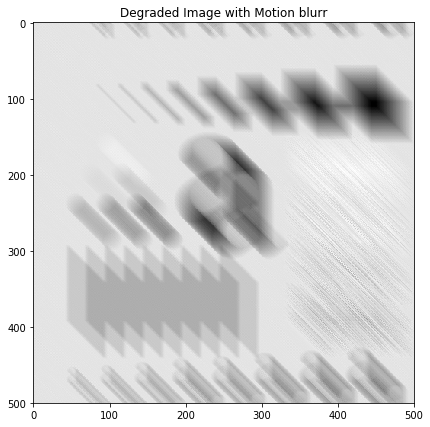

In [23]:
# getting back degraded image from it's FFT using IFFT function of numpy
degraded_image_fft = fft_shifted_image * degradation_maskB
degraded_image = np.fft.ifft2(degraded_image_fft, s=None, axes=(-2, -1), norm=None)
degraded_image = rescale(degraded_image)

plt.imshow(degraded_image, cmap = 'gray')
plt.title('Degraded Image with Motion blurr')
plt.show()

<h2> Now approach to complete all the tasks in Question 2 will be same as Question. The only difference will be in
degradation mask. Rest will be more or less same </h2>

<p>For more clarity refer to similar code snippet in Question 1.(Explained in detail there)</p>

In [24]:
# adding noise to degraded images
noisy_degraded_images = {}
G_noises = {}
for i in range(0,26, 5):
    
    G_noises[str(i)+'%'] = gaussian_noise(np.max(image)*(i)/100)
    noisy_degraded_images[str(i)+ '%'] = degraded_image + G_noises[str(i)+'%']

In [25]:
# calculating FFT of degraded noisy images
noisy_degraded_images_fft = {}
for i in range(0, 26, 5):
    noisy_degraded_images_fft[str(i)+'%']= np.fft.fft2(noisy_degraded_images[str(i)+ '%'], s=image.shape, axes=(-2, -1), norm=None )
    noisy_degraded_images_fft[str(i)+ '%']= np.fft.fftshift(noisy_degraded_images_fft[str(i)+ '%'])

<h1> Let's start inverse filtering </h1>

In [26]:
# Here we do the inverse filtering in the same manner as question 1.
inverse_filtered_fft = {}
for index in range(0, 26, 5):
    inverse_filtered_fft[str(index)+ '%'] = (0+0j)*np.zeros(degradation_maskB.shape)
    
    for i in range(degradation_maskB.shape[0]):
        for j in range(degradation_maskB.shape[1]):
            
            if np.abs(degradation_maskB[i, j]) < 0.08:
                inverse_filtered_fft[str(index)+ '%'][i, j] = noisy_degraded_images_fft[str(index)+ '%'][i,j]
            else:
                inverse_filtered_fft[str(index)+ '%'][i, j] = noisy_degraded_images_fft[str(index)+ '%'][i,j] / degradation_maskB[i, j]
                
    inverse_filtered_fft[str(index)+'%'] *= butterworth_LP_filter_mask

In [27]:
# Getting Inverse Filtered Images from their corresponding FFTs using IFFT function of numpy
inverse_filtered_images = {}
for i in range(0, 26, 5):
    inverse_filtered_images[str(i)+"%"] = rescale(np.fft.ifft2(inverse_filtered_fft[str(i)+ '%'], s=None, axes=(-2, -1), norm=None))[0:500,0:500]

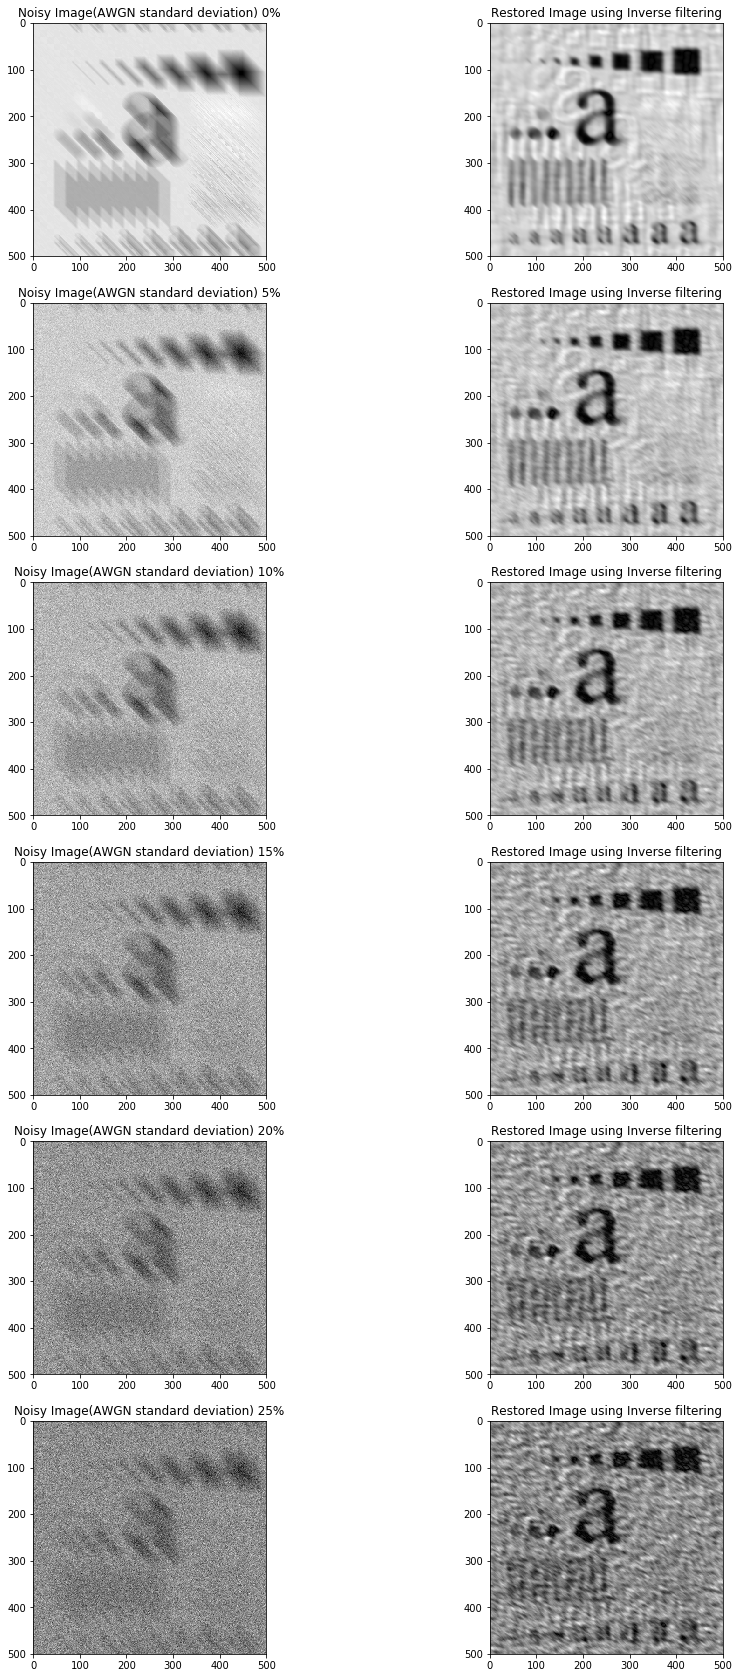

In [28]:
# Plotting the results
fig = plt.figure(figsize = (15,30))
count = 1
for index in range(0, 26, 5):
    ax = fig.add_subplot(6, 2, count)
    plt.imshow(noisy_degraded_images[str(index)+'%'], cmap = 'gray')
    ax.set_title("Noisy Image(AWGN standard deviation) "+ str(index)+'%')
    
    ax = fig.add_subplot(6, 2, count+1)
    plt.imshow(inverse_filtered_images[str(index)+'%'], cmap = 'gray')
    ax.set_title("Restored Image using Inverse filtering")
    count += 2

<h3>(i) RRMSE of degraded image w.r.t. original image versus standard deviation of noise.
    <br>(ii) RRMSE of Inverse filtered image w.r.t. original image versus standard deviation of noise.</h3>

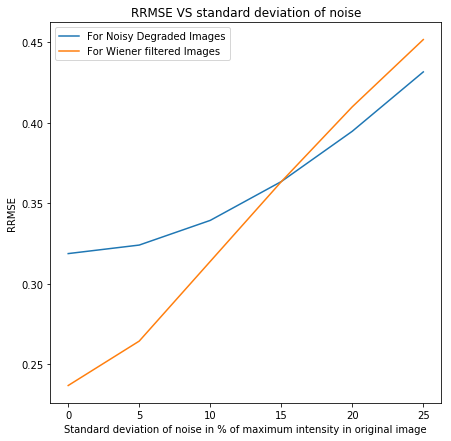

In [29]:
RRMSE = []
for i in range(0, 26, 5):
    RRMSE.append(rrmse(noisy_degraded_images[str(i)+'%'], image))

plt.plot(np.arange(0,26, 5), RRMSE, label = 'For Noisy Degraded Images')


RRMSE = []
for i in range(0, 26, 5):
    RRMSE.append(rrmse(inverse_filtered_images[str(i)+'%'], image))

plt.plot(np.arange(0,26, 5), RRMSE, label = 'For Wiener filtered Images')
plt.xlabel("Standard deviation of noise in % of maximum intensity in original image")
plt.ylabel("RRMSE")
plt.title("RRMSE VS standard deviation of noise")
plt.legend()
plt.show()

In [30]:
G_noises['0%'] = gaussian_noise(np.max(image)*(1.5)/100)
noisy_degraded_images['0%'] = degraded_image + G_noises['0%']
gaussian_noise_PSDs['0%'] = np.square(np.abs(np.fft.fftshift(np.fft.fft2(G_noises['0%'], s=image.shape, axes=(-2, -1), norm=None ))))

<h1>part b)</h1> 
<p>Perform inverse filtering on the degraded image at the different levels of zero mean i.i.d. Gaussian noise,
    namely standard deviation = <b>0%, 5%, 10%, 15%, 20%, 25% </b>of maximum intensity in original image. Plot the
    following 2 curves in a graph- <b>(i)</b> RRMSE of degraded image w.r.t. original image versus standard deviation of
    noise. <b>(ii)</b> RRMSE of filtered image w.r.t. original image versus standard deviation of noise.</p>

<h2> Wiener Filtering </h2>

In [31]:
# wiener filter does work as inverse filter if noise 
wiener_filtered_images = {}
for i in range(0, 26, 5):
    K = gaussian_noise_PSDs[str(i) + '%'] / np.square(np.abs(fft_shifted_image))
        
    # implementation of Wiener filter 
    temp = np.square(np.abs(degradation_maskB)) / (degradation_maskB *(np.square(np.abs(degradation_maskB)) + K))

    fft_im = temp * noisy_degraded_images_fft[str(i)+'%']
    wiener_filtered_images[str(i)+'%'] = rescale(np.fft.ifft2(fft_im, s=None, axes=(-2, -1), norm=None))

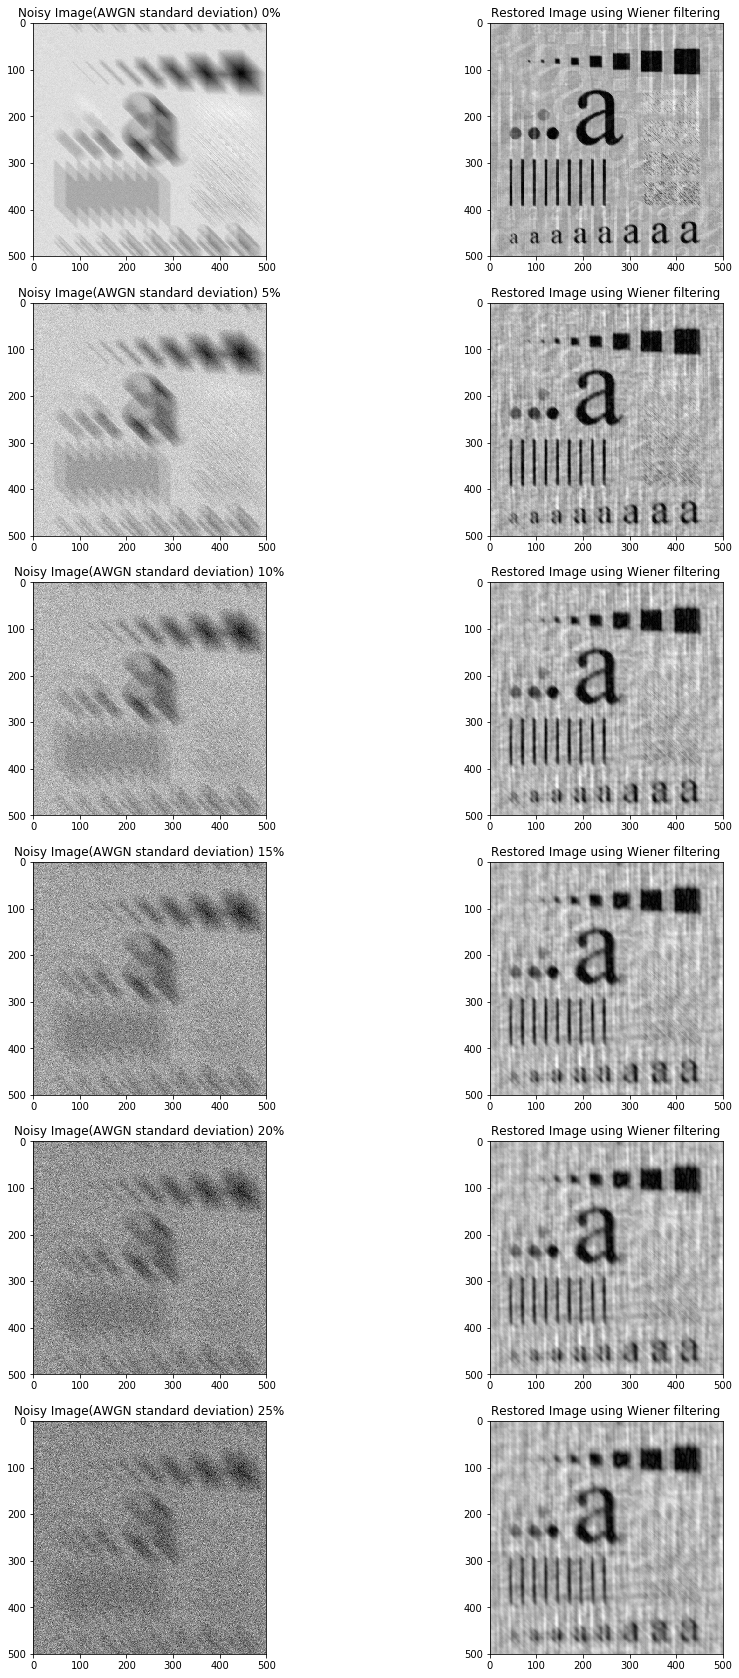

In [32]:
# Plotting the results
fig = plt.figure(figsize = (15,30))
count = 1
for index in range(0, 26, 5):
    ax = fig.add_subplot(6, 2, count)
    plt.imshow(noisy_degraded_images[str(index)+'%'], cmap = 'gray')
    ax.set_title("Noisy Image(AWGN standard deviation) "+ str(index)+'%')
    
    ax = fig.add_subplot(6, 2, count+1)
    plt.imshow(wiener_filtered_images[str(index)+'%'], cmap = 'gray')
    ax.set_title("Restored Image using Wiener filtering")
    count += 2

<h3>(i) RRMSE of degraded image w.r.t. original image versus standard deviation of noise.
<br>(ii) RRMSE of Wiener Filtered Image w.r.t. original image versus standard deviation of noise</h3>    

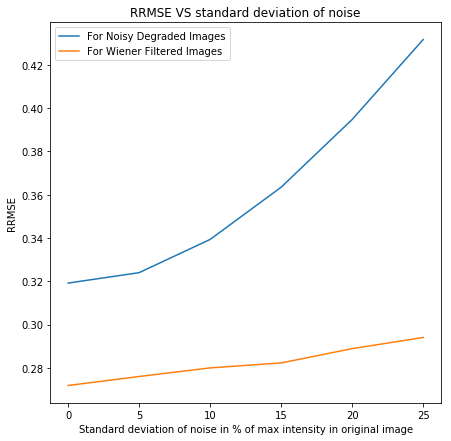

In [34]:
RRMSE = []
for i in range(0, 26, 5):
    RRMSE.append(rrmse(noisy_degraded_images[str(i)+'%'], image))

plt.plot(np.arange(0,26, 5), RRMSE , label = 'For Noisy Degraded Images')

RRMSE = []
for i in range(0, 26, 5):
    RRMSE.append(rrmse(wiener_filtered_images[str(i)+'%'], image))
plt.plot(np.arange(0,26, 5), RRMSE, label = 'For Wiener Filtered Images')
plt.xlabel("Standard deviation of noise in % of max intensity in original image")
plt.ylabel("RRMSE")
plt.title("RRMSE VS standard deviation of noise")
plt.legend()
plt.show()

#        ================== The End ===================